The aim is to solve the challenge of predicting whether a photograph is likely to be popular and generate a significant number of downloads. Datasets are accessed from kaggle competition (https://www.kaggle.com/competitions/can-i-be-an-influencer/overview)

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/can-i-be-an-influencer/sample_submission.csv
/kaggle/input/can-i-be-an-influencer/test_colors.csv
/kaggle/input/can-i-be-an-influencer/test_keywords.csv
/kaggle/input/can-i-be-an-influencer/train.csv
/kaggle/input/can-i-be-an-influencer/train_colors.csv
/kaggle/input/can-i-be-an-influencer/test.csv
/kaggle/input/can-i-be-an-influencer/train_keywords.csv


In [2]:
# Reading data
train = pd.read_csv('/kaggle/input/can-i-be-an-influencer/train.csv')
train_clr = pd.read_csv('/kaggle/input/can-i-be-an-influencer/train_colors.csv')
train_kw = pd.read_csv('/kaggle/input/can-i-be-an-influencer/train_keywords.csv')
test = pd.read_csv('/kaggle/input/can-i-be-an-influencer/test.csv')
test_kw = pd.read_csv('/kaggle/input/can-i-be-an-influencer/test_keywords.csv')

In [3]:
# Importing Libraries

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pylab as plt
from matplotlib import pyplot
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score, precision_score, recall_score, roc_auc_score, roc_curve
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn import datasets, linear_model
from sklearn.metrics import accuracy_score,classification_report
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier,AdaBoostClassifier
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet, SGDRegressor
from sklearn.model_selection import  train_test_split
from sklearn import metrics
from sklearn.model_selection import KFold
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

In [4]:
train.head()

,image_id,photo_url,photo_image_url,photo_submitted_at,obs_day,obs_hour,obs_min,obs_sec,image_category,width,...,iso,aperture_value,focal_length,exposure_time,latitude,longitude,country,city,total_days,stats_downloads
0,68105c019b,https://unsplash.com/photos/7AcMUSYRZpU,https://images.unsplash.com/photo-147455715737...,2016-09-22 15:13:10.134081,Thursday,15,13,10,Featured,2592,...,200.0,14.0,50.0,1/60,NaN,NaN,USA,"Wichita, Kansas",2361,167503
1,06d11c4edd,https://unsplash.com/photos/grWwLCSRr4o,https://images.unsplash.com/photo-157005349769...,2019-10-02 21:59:51.712464,Wednesday,21,59,51,Featured,4000,...,100.0,2.5,30.0,1/1250,NaN,NaN,NaN,NaN,1255,1839
2,f6599edba1,https://unsplash.com/photos/OR4q9_Y2nuY,https://images.unsplash.com/photo-158018448188...,2020-01-28 04:10:11.128061,Tuesday,4,10,11,Featured,5504,...,64.0,2.8,48.0,1/1600,NaN,NaN,NaN,NaN,1138,787
3,0f4bcc2d36,https://unsplash.com/photos/Qc3AmsZ3g2A,https://images.unsplash.com/photo-1542066365-0...,2018-11-12 23:46:21.990378,Monday,23,46,21,Featured,3627,...,139.0,2.2,4.7,1/100,32.784562,-79.785303,United States,Isle of Palms,1579,2049
4,74db502ed5,https://unsplash.com/photos/6BLE9HVwIJw,https://images.unsplash.com/photo-158781208024...,2020-04-25 11:04:20.912527,Saturday,11,4,20,Featured,4896,...,400.0,6.4,22.2,1/420,66.074878,-23.125068,Island,Ísafjörður,1050,2982


In [5]:
## Transformations performed to combine information from keyword dataset with the main training dataset
# Take maximum of confidence value in keyword data to retain most relevant keyword record for each image
trainkw_temp = train_kw.groupby('image_id', as_index=False)[['confidence_value']].max()
train_main = pd.merge(train, trainkw_temp, how='inner', on=['image_id'])
train_kw_cleaned = pd.merge(train_kw, trainkw_temp, how='inner', on=['image_id', 'confidence_value'])

trainkw_occurence = train_kw.groupby(['classification_keyword']).size().reset_index(name='count')

# Sort the dataframe by the column with the number of occurrences of each keyword in descending order
trainkw_occurence = trainkw_occurence.sort_values(by='count', ascending=False).reset_index()

# Create a new column to hold the rank values
trainkw_occurence['rank'] = trainkw_occurence.index.values
    
trainkw_ranked = pd.merge(train_kw_cleaned, trainkw_occurence, how='left', on=['classification_keyword']).groupby('image_id', as_index=False).apply(lambda x: x[x['rank'] == x['rank'].min()]).reset_index()
trainkw_ranked.drop(['index','count','rank','level_0','level_1'], axis=1, inplace=True)
# original training data with key words data
train_withkw = pd.merge(train, trainkw_ranked, how='left', on=['image_id'])
train_withkw.head()

,image_id,photo_url,photo_image_url,photo_submitted_at,obs_day,obs_hour,obs_min,obs_sec,image_category,width,...,exposure_time,latitude,longitude,country,city,total_days,stats_downloads,image_classification,classification_keyword,confidence_value
0,68105c019b,https://unsplash.com/photos/7AcMUSYRZpU,https://images.unsplash.com/photo-147455715737...,2016-09-22 15:13:10.134081,Thursday,15,13,10,Featured,2592,...,1/60,NaN,NaN,USA,"Wichita, Kansas",2361,167503,Suggested,plant,99.158722
1,06d11c4edd,https://unsplash.com/photos/grWwLCSRr4o,https://images.unsplash.com/photo-157005349769...,2019-10-02 21:59:51.712464,Wednesday,21,59,51,Featured,4000,...,1/1250,NaN,NaN,NaN,NaN,1255,1839,Predicted,soil,99.999489
2,f6599edba1,https://unsplash.com/photos/OR4q9_Y2nuY,https://images.unsplash.com/photo-158018448188...,2020-01-28 04:10:11.128061,Tuesday,4,10,11,Featured,5504,...,1/1600,NaN,NaN,NaN,NaN,1138,787,Predicted,nature,99.871567
3,0f4bcc2d36,https://unsplash.com/photos/Qc3AmsZ3g2A,https://images.unsplash.com/photo-1542066365-0...,2018-11-12 23:46:21.990378,Monday,23,46,21,Featured,3627,...,1/100,32.784562,-79.785303,United States,Isle of Palms,1579,2049,Predicted,water,99.955086
4,74db502ed5,https://unsplash.com/photos/6BLE9HVwIJw,https://images.unsplash.com/photo-158781208024...,2020-04-25 11:04:20.912527,Saturday,11,4,20,Featured,4896,...,1/420,66.074878,-23.125068,Island,Ísafjörður,1050,2982,Suggested,nature,99.912849


In [6]:
## Repeating the same steps for test data as performed on training data above
testkw_temp = test_kw.groupby('image_id', as_index=False)[['confidence_value']].max()
# testkw_temp
test_main = pd.merge(test, testkw_temp, how='inner', on=['image_id'])
# test_main
test_kw_cleaned = pd.merge(test_kw, testkw_temp, how='inner', on=['image_id', 'confidence_value'])
# test_kw_cleaned
testkw_occurence = test_kw.groupby(['classification_keyword']).size().reset_index(name='count')

# Sort the dataframe by the column with the number of occurrences of each keyword in descending order
testkw_occurence = testkw_occurence.sort_values(by='count', ascending=False).reset_index()

# # Create a new column to hold the rank values
testkw_occurence['rank'] = testkw_occurence.index.values
    
# testkw_occurence
testkw_ranked = pd.merge(test_kw_cleaned, testkw_occurence, how='left', on=['classification_keyword']).groupby('image_id', as_index=False).apply(lambda x: x[x['rank'] == x['rank'].min()]).reset_index()
# testkw_ranked
testkw_ranked.drop(['index','count','rank','level_0','level_1'], axis=1, inplace=True)
# testkw_ranked.head()
# original testing data with key words data
test_withkw = pd.merge(test, testkw_ranked, how='left', on=['image_id'])
test_withkw.head()

,image_id,photo_url,photo_image_url,photo_submitted_at,obs_day,obs_hour,obs_min,obs_sec,image_category,width,...,focal_length,exposure_time,latitude,longitude,country,city,total_days,image_classification,classification_keyword,confidence_value
0,2322208d63,https://unsplash.com/photos/FuX1NIv8lLk,https://images.unsplash.com/photo-157063155096...,2019-10-09 14:32:57.822408,Wednesday,14,32,57,Featured,4016,...,50.0,1/640,NaN,NaN,NaN,NaN,1249,Predicted,plant,99.867035
1,847b5fcee1,https://unsplash.com/photos/t5rBtxLiHj8,https://images.unsplash.com/photo-157392442935...,2019-11-16 17:15:26.021693,Saturday,17,15,26,Featured,6240,...,300.0,1/200,57.273628,-6.215502,Royaume-Uni,NaN,1211,Predicted,animal,98.562889
2,0e1a37b065,https://unsplash.com/photos/9jdlJzl6yN8,https://images.unsplash.com/photo-1554188068-3...,2019-04-02 06:54:42.103328,Tuesday,6,54,42,Featured,5472,...,50.0,1/1000,NaN,NaN,NaN,NaN,1439,Predicted,nature,99.946297
3,8c8c9d4355,https://unsplash.com/photos/qAbR6rwlCrg,https://images.unsplash.com/photo-157538454351...,2019-12-03 14:49:46.298627,Tuesday,14,49,46,Featured,4000,...,85.0,1/200,NaN,NaN,NaN,NaN,1194,Predicted,soil,99.999969
4,8ff19c3747,https://unsplash.com/photos/-S6R1ePsKEc,https://images.unsplash.com/photo-1552613545-3...,2019-03-15 01:32:29.162786,Friday,1,32,29,Featured,6000,...,93.0,1/160,NaN,NaN,NaN,NaN,1457,Predicted,plant,99.999527


In [7]:
train.corr()

,obs_hour,obs_min,obs_sec,width,height,aspect_ratio,iso,aperture_value,focal_length,latitude,longitude,total_days,stats_downloads
obs_hour,1.000000,-0.010468,0.006778,-0.015422,-0.014454,-0.002660,-0.019113,0.008707,-0.005258,0.110486,-0.004354,0.017434,-0.004241
obs_min,-0.010468,1.000000,-0.010195,-0.000377,-0.007055,0.005342,-0.016538,-0.005723,-0.012002,-0.034974,0.033722,0.012467,0.006262
obs_sec,0.006778,-0.010195,1.000000,0.009928,0.023508,-0.011045,0.007944,-0.013382,-0.002613,-0.001196,-0.014321,-0.006884,0.008159
width,-0.015422,-0.000377,0.009928,1.000000,0.146659,0.601535,0.038970,0.111747,0.088184,0.012111,-0.057518,0.042229,-0.017073
height,-0.014454,-0.007055,0.023508,0.146659,1.000000,-0.663945,0.027508,-0.057297,-0.004536,0.035806,-0.014804,-0.368445,-0.099657
aspect_ratio,-0.002660,0.005342,-0.011045,0.601535,-0.663945,1.000000,0.007350,0.139267,0.075458,-0.018169,-0.035035,0.358594,0.070788
iso,-0.019113,-0.016538,0.007944,0.038970,0.027508,0.007350,1.000000,-0.034085,0.052211,-0.000185,-0.003327,-0.025526,0.002131
aperture_value,0.008707,-0.005723,-0.013382,0.111747,-0.057297,0.139267,-0.034085,1.000000,0.134524,-0.000043,-0.019795,0.126184,0.048999
focal_length,-0.005258,-0.012002,-0.002613,0.088184,-0.004536,0.075458,0.052211,0.134524,1.000000,-0.041824,-0.014796,-0.052114,-0.010577
latitude,0.110486,-0.034974,-0.001196,0.012111,0.035806,-0.018169,-0.000185,-0.000043,-0.041824,1.000000,-0.388386,0.013743,0.006215


<AxesSubplot:>

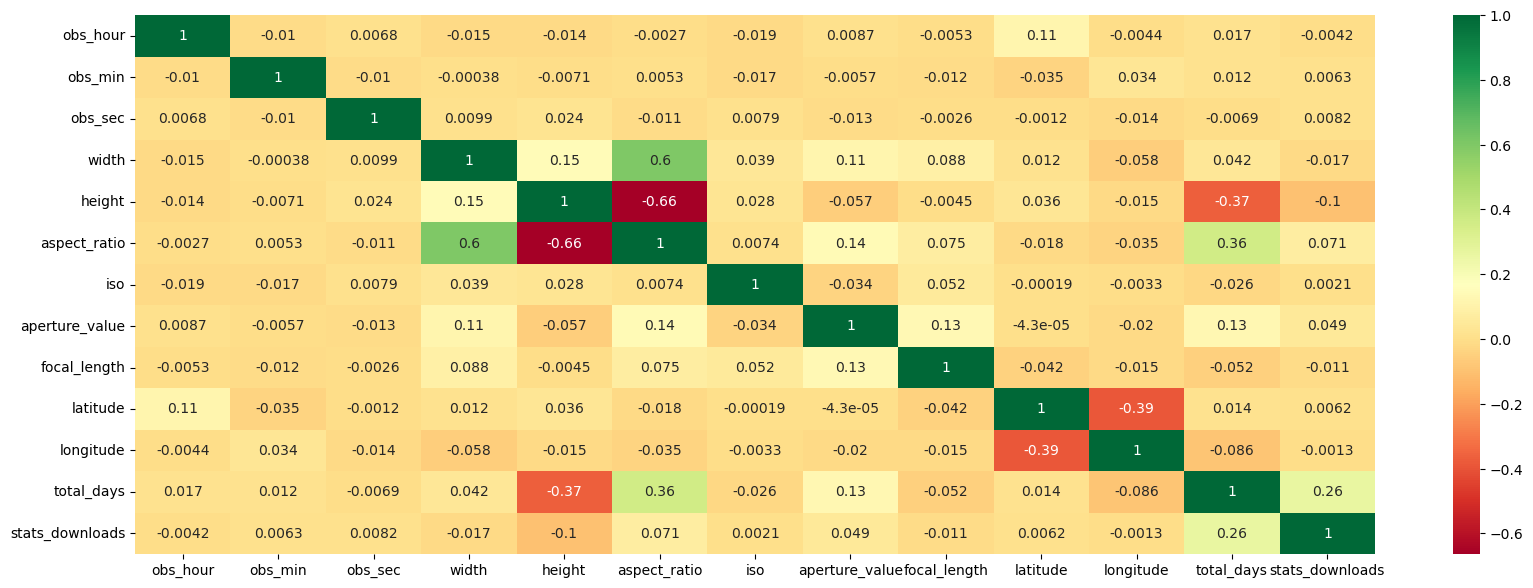

In [8]:
# Correlation Heatmap
plt.figure(figsize=(20,7))
sns.heatmap(train.corr(), annot=True, cmap='RdYlGn')

In [9]:
train.columns

Index(['image_id', 'photo_url', 'photo_image_url', 'photo_submitted_at',
       'obs_day', 'obs_hour', 'obs_min', 'obs_sec', 'image_category', 'width',
       'height', 'aspect_ratio', 'description1', 'description2', 'camera_make',
       'camera_model', 'iso', 'aperture_value', 'focal_length',
       'exposure_time', 'latitude', 'longitude', 'country', 'city',
       'total_days', 'stats_downloads'],
      dtype='object')

In [10]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12197 entries, 0 to 12196
Data columns (total 26 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   image_id            12197 non-null  object 
 1   photo_url           12197 non-null  object 
 2   photo_image_url     12197 non-null  object 
 3   photo_submitted_at  12197 non-null  object 
 4   obs_day             12197 non-null  object 
 5   obs_hour            12197 non-null  int64  
 6   obs_min             12197 non-null  int64  
 7   obs_sec             12197 non-null  int64  
 8   image_category      12197 non-null  object 
 9   width               12197 non-null  int64  
 10  height              12197 non-null  int64  
 11  aspect_ratio        12197 non-null  float64
 12  description1        5151 non-null   object 
 13  description2        11544 non-null  object 
 14  camera_make         12157 non-null  object 
 15  camera_model        12149 non-null  object 
 16  iso 

In [11]:
total = train_withkw.isnull().sum().sort_values(ascending=False)
percent = (train_withkw.isnull().sum()/train_withkw.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data

,Total,Percent
city,9147,0.749939
longitude,8725,0.715340
latitude,8723,0.715176
country,7908,0.648356
description1,7046,0.577683
description2,653,0.053538
iso,55,0.004509
exposure_time,48,0.003935
camera_model,48,0.003935
camera_make,40,0.003279


In [12]:
train_withkw.shape

(12197, 29)

In [13]:
n = train_withkw.nunique(axis=0)
  
print("No.of.unique values in each column :\n",
      n)

No.of.unique values in each column :
 image_id                  12197
photo_url                 12197
photo_image_url           12197
photo_submitted_at        12187
obs_day                       7
obs_hour                     24
obs_min                      60
obs_sec                      60
image_category                2
width                      2792
height                     2894
aspect_ratio                171
description1               4911
description2               9886
camera_make                  80
camera_model                650
iso                         129
aperture_value               83
focal_length                492
exposure_time               442
latitude                   2635
longitude                  2667
country                     299
city                       1893
total_days                 1778
stats_downloads            7260
image_classification          2
classification_keyword      183
confidence_value          11620
dtype: int64


In [14]:
# Label encoding the categorical features
from sklearn.preprocessing import LabelEncoder
scaler = LabelEncoder()
df = train_withkw.copy()
df['image_id'] = scaler.fit_transform(df['image_id'])
df['image_classification'] = scaler.fit_transform(df['image_classification'])
df['classification_keyword'] = scaler.fit_transform(df['classification_keyword'])

In [15]:
# Drop the columns with high amount of missing data as the features would make the model bias
df.drop(['city',
'longitude',
'latitude',
'country',
'description1',
'description2'], axis=1, inplace=True)

df.head()


,image_id,photo_url,photo_image_url,photo_submitted_at,obs_day,obs_hour,obs_min,obs_sec,image_category,width,...,camera_model,iso,aperture_value,focal_length,exposure_time,total_days,stats_downloads,image_classification,classification_keyword,confidence_value
0,5047,https://unsplash.com/photos/7AcMUSYRZpU,https://images.unsplash.com/photo-147455715737...,2016-09-22 15:13:10.134081,Thursday,15,13,10,Featured,2592,...,Canon EOS 60D,200.0,14.0,50.0,1/60,2361,167503,1,115,99.158722
1,328,https://unsplash.com/photos/grWwLCSRr4o,https://images.unsplash.com/photo-157005349769...,2019-10-02 21:59:51.712464,Wednesday,21,59,51,Featured,4000,...,ILCE-6500,100.0,2.5,30.0,1/1250,1255,1839,0,142,99.999489
2,11708,https://unsplash.com/photos/OR4q9_Y2nuY,https://images.unsplash.com/photo-158018448188...,2020-01-28 04:10:11.128061,Tuesday,4,10,11,Featured,5504,...,NIKON D850,64.0,2.8,48.0,1/1600,1138,787,0,104,99.871567
3,725,https://unsplash.com/photos/Qc3AmsZ3g2A,https://images.unsplash.com/photo-1542066365-0...,2018-11-12 23:46:21.990378,Monday,23,46,21,Featured,3627,...,FC220,139.0,2.2,4.7,1/100,1579,2049,0,172,99.955086
4,5614,https://unsplash.com/photos/6BLE9HVwIJw,https://images.unsplash.com/photo-158781208024...,2020-04-25 11:04:20.912527,Saturday,11,4,20,Featured,4896,...,X-T10,400.0,6.4,22.2,1/420,1050,2982,1,104,99.912849


In [16]:
test_withkw.drop(['city',
'longitude',
'latitude',
'country',
'description1',
'description2'], axis=1, inplace=True)

test.head()

,image_id,photo_url,photo_image_url,photo_submitted_at,obs_day,obs_hour,obs_min,obs_sec,image_category,width,...,camera_model,iso,aperture_value,focal_length,exposure_time,latitude,longitude,country,city,total_days
0,2322208d63,https://unsplash.com/photos/FuX1NIv8lLk,https://images.unsplash.com/photo-157063155096...,2019-10-09 14:32:57.822408,Wednesday,14,32,57,Featured,4016,...,NIKON D750,100.0,4.5,50.0,1/640,NaN,NaN,NaN,NaN,1249
1,847b5fcee1,https://unsplash.com/photos/t5rBtxLiHj8,https://images.unsplash.com/photo-157392442935...,2019-11-16 17:15:26.021693,Saturday,17,15,26,Featured,6240,...,Canon EOS 6D Mark II,100.0,5.6,300.0,1/200,57.273628,-6.215502,Royaume-Uni,NaN,1211
2,0e1a37b065,https://unsplash.com/photos/9jdlJzl6yN8,https://images.unsplash.com/photo-1554188068-3...,2019-04-02 06:54:42.103328,Tuesday,6,54,42,Featured,5472,...,Canon EOS 6D,100.0,7.1,50.0,1/1000,NaN,NaN,NaN,NaN,1439
3,8c8c9d4355,https://unsplash.com/photos/qAbR6rwlCrg,https://images.unsplash.com/photo-157538454351...,2019-12-03 14:49:46.298627,Tuesday,14,49,46,Featured,4000,...,ILCE-7M2,100.0,8.0,85.0,1/200,NaN,NaN,NaN,NaN,1194
4,8ff19c3747,https://unsplash.com/photos/-S6R1ePsKEc,https://images.unsplash.com/photo-1552613545-3...,2019-03-15 01:32:29.162786,Friday,1,32,29,Featured,6000,...,ILCE-6000,160.0,5.6,93.0,1/160,NaN,NaN,NaN,NaN,1457


In [17]:
df.drop(['photo_url', 'photo_image_url'], axis=1, inplace=True)
df.head()

,image_id,photo_submitted_at,obs_day,obs_hour,obs_min,obs_sec,image_category,width,height,aspect_ratio,...,camera_model,iso,aperture_value,focal_length,exposure_time,total_days,stats_downloads,image_classification,classification_keyword,confidence_value
0,5047,2016-09-22 15:13:10.134081,Thursday,15,13,10,Featured,2592,1728,1.50,...,Canon EOS 60D,200.0,14.0,50.0,1/60,2361,167503,1,115,99.158722
1,328,2019-10-02 21:59:51.712464,Wednesday,21,59,51,Featured,4000,6000,0.67,...,ILCE-6500,100.0,2.5,30.0,1/1250,1255,1839,0,142,99.999489
2,11708,2020-01-28 04:10:11.128061,Tuesday,4,10,11,Featured,5504,8256,0.67,...,NIKON D850,64.0,2.8,48.0,1/1600,1138,787,0,104,99.871567
3,725,2018-11-12 23:46:21.990378,Monday,23,46,21,Featured,3627,2040,1.78,...,FC220,139.0,2.2,4.7,1/100,1579,2049,0,172,99.955086
4,5614,2020-04-25 11:04:20.912527,Saturday,11,4,20,Featured,4896,3264,1.50,...,X-T10,400.0,6.4,22.2,1/420,1050,2982,1,104,99.912849


In [18]:
test_withkw.drop(['photo_url', 'photo_image_url'], axis=1, inplace=True)
test_withkw.head()

,image_id,photo_submitted_at,obs_day,obs_hour,obs_min,obs_sec,image_category,width,height,aspect_ratio,camera_make,camera_model,iso,aperture_value,focal_length,exposure_time,total_days,image_classification,classification_keyword,confidence_value
0,2322208d63,2019-10-09 14:32:57.822408,Wednesday,14,32,57,Featured,4016,6016,0.67,NIKON CORPORATION,NIKON D750,100.0,4.5,50.0,1/640,1249,Predicted,plant,99.867035
1,847b5fcee1,2019-11-16 17:15:26.021693,Saturday,17,15,26,Featured,6240,4160,1.50,Canon,Canon EOS 6D Mark II,100.0,5.6,300.0,1/200,1211,Predicted,animal,98.562889
2,0e1a37b065,2019-04-02 06:54:42.103328,Tuesday,6,54,42,Featured,5472,3648,1.50,Canon,Canon EOS 6D,100.0,7.1,50.0,1/1000,1439,Predicted,nature,99.946297
3,8c8c9d4355,2019-12-03 14:49:46.298627,Tuesday,14,49,46,Featured,4000,6000,0.67,SONY,ILCE-7M2,100.0,8.0,85.0,1/200,1194,Predicted,soil,99.999969
4,8ff19c3747,2019-03-15 01:32:29.162786,Friday,1,32,29,Featured,6000,4000,1.50,SONY,ILCE-6000,160.0,5.6,93.0,1/160,1457,Predicted,plant,99.999527


In [19]:
# Label encoding the categorical features
df['obs_day'] = scaler.fit_transform(df['obs_day'])
df['image_category'] = scaler.fit_transform(df['image_category'])
df['camera_make'] = scaler.fit_transform(df['camera_make'])
df['camera_model'] = scaler.fit_transform(df['camera_model'])
test_withkw['image_category'] = scaler.fit_transform(test_withkw['image_category'])

df.head()

,image_id,photo_submitted_at,obs_day,obs_hour,obs_min,obs_sec,image_category,width,height,aspect_ratio,...,camera_model,iso,aperture_value,focal_length,exposure_time,total_days,stats_downloads,image_classification,classification_keyword,confidence_value
0,5047,2016-09-22 15:13:10.134081,4,15,13,10,0,2592,1728,1.50,...,92,200.0,14.0,50.0,1/60,2361,167503,1,115,99.158722
1,328,2019-10-02 21:59:51.712464,6,21,59,51,0,4000,6000,0.67,...,377,100.0,2.5,30.0,1/1250,1255,1839,0,142,99.999489
2,11708,2020-01-28 04:10:11.128061,5,4,10,11,0,5504,8256,0.67,...,477,64.0,2.8,48.0,1/1600,1138,787,0,104,99.871567
3,725,2018-11-12 23:46:21.990378,1,23,46,21,0,3627,2040,1.78,...,324,139.0,2.2,4.7,1/100,1579,2049,0,172,99.955086
4,5614,2020-04-25 11:04:20.912527,2,11,4,20,0,4896,3264,1.50,...,587,400.0,6.4,22.2,1/420,1050,2982,1,104,99.912849


In [20]:
df.dtypes

image_id                    int64
photo_submitted_at         object
obs_day                     int64
obs_hour                    int64
obs_min                     int64
obs_sec                     int64
image_category              int64
width                       int64
height                      int64
aspect_ratio              float64
camera_make                 int64
camera_model                int64
iso                       float64
aperture_value            float64
focal_length              float64
exposure_time              object
total_days                  int64
stats_downloads             int64
image_classification        int64
classification_keyword      int64
confidence_value          float64
dtype: object

In [21]:
category = df['exposure_time'].unique()
category

array(['1/60', '1/1250', '1/1600', '1/100', '1/420', '13', '1/2500',
       '1/500', '1/2000', '1/400', '1/250', '1/125', '1/2623', '1/30',
       '1/180', '20', '1/1000', '1/320', '1/200', '1/10', '1/4000',
       '1/160', '1/140', '1/640', '500', '1/750', '1/800', '1/122', nan,
       '1/40', '1/80', '30', '4', '1/13', '1/8000', '1/50', '1/120',
       '1/25', '1/3597', '25', '1/1350', '1/440', '1/2400', '0.8', '0.5',
       '1/755', '1/580', '1/3200', '1/350', '35', '1/90', '1', '1/4',
       '1/725', '1/55', '5', '1/3049', '1/5000', '32', '15', '1/5', '300',
       '1/15', '1/6400', '1/240', '1/1808', '52', '0.3', '1/1300', '2',
       '1/8', '1/75', '1/336', '16', '1/20', '1/924', '1/150', '1/210',
       '10', '1/110', '1/450', '1/1700', '23', '1/18', '1/105', '1/620',
       '1/2083', '1/130', '9.6', '1214', '1/300', '1/4673', '1/132',
       '1/1400', '1/1667', '1/2933', '1/357', '1/22', '136.6', '1/302',
       '30s', '1/220', '1/1261', '1.6', '360', '1/401', '1/41', '1/5800',

In [22]:
# Label encoding the categorical features
df['exposure_time'] = scaler.fit_transform(df['exposure_time'])
df

,image_id,photo_submitted_at,obs_day,obs_hour,obs_min,obs_sec,image_category,width,height,aspect_ratio,...,camera_model,iso,aperture_value,focal_length,exposure_time,total_days,stats_downloads,image_classification,classification_keyword,confidence_value
0,5047,2016-09-22 15:13:10.134081,4,15,13,10,0,2592,1728,1.50,...,92,200.0,14.0,50.0,287,2361,167503,1,115,99.158722
1,328,2019-10-02 21:59:51.712464,6,21,59,51,0,4000,6000,0.67,...,377,100.0,2.5,30.0,51,1255,1839,0,142,99.999489
2,11708,2020-01-28 04:10:11.128061,5,4,10,11,0,5504,8256,0.67,...,477,64.0,2.8,48.0,95,1138,787,0,104,99.871567
3,725,2018-11-12 23:46:21.990378,1,23,46,21,0,3627,2040,1.78,...,324,139.0,2.2,4.7,17,1579,2049,0,172,99.955086
4,5614,2020-04-25 11:04:20.912527,2,11,4,20,0,4896,3264,1.50,...,587,400.0,6.4,22.2,234,1050,2982,1,104,99.912849
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12192,1185,2019-09-23 13:07:25.355936,1,13,7,25,0,4480,6111,0.73,...,88,100.0,5.6,300.0,226,1265,2353,1,104,99.637810
12193,11176,2019-01-28 20:32:28.827831,1,20,32,28,0,2403,3337,0.72,...,87,400.0,5.0,100.0,196,1503,3541,0,6,96.121124
12194,5545,2016-05-05 01:54:16.982329,4,1,54,16,0,5184,3456,1.50,...,119,400.0,4.0,21.0,227,2501,14581,1,172,77.655396
12195,11541,2016-04-28 18:02:32.922228,4,18,2,32,0,6000,4000,1.50,...,458,800.0,1.8,50.0,196,2508,9247,1,115,92.314514


In [23]:
df.dtypes

image_id                    int64
photo_submitted_at         object
obs_day                     int64
obs_hour                    int64
obs_min                     int64
obs_sec                     int64
image_category              int64
width                       int64
height                      int64
aspect_ratio              float64
camera_make                 int64
camera_model                int64
iso                       float64
aperture_value            float64
focal_length              float64
exposure_time               int64
total_days                  int64
stats_downloads             int64
image_classification        int64
classification_keyword      int64
confidence_value          float64
dtype: object

<AxesSubplot:>

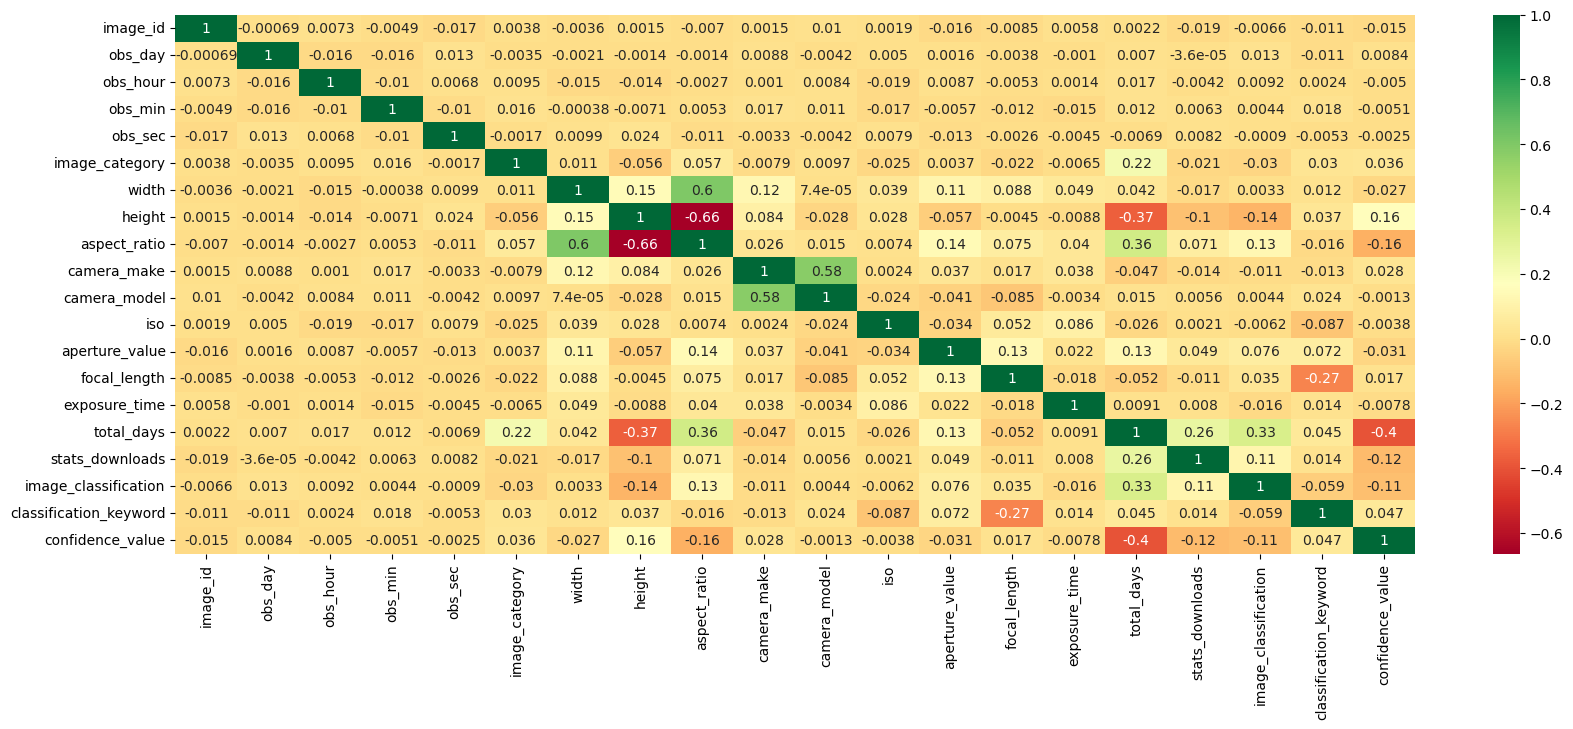

In [24]:
# Correlation Heatmap
plt.figure(figsize=(20,7))
sns.heatmap(df.corr(), annot=True, cmap='RdYlGn')

In [25]:
# Imputing missing values with mean for numerical and mode for categories
df['iso'] = df['iso'].fillna(value=df.iso.mean())
df['exposure_time'] = df['exposure_time'].fillna(value=df.exposure_time.mode())
df['camera_model'] = df['camera_model'].fillna(value=df.camera_model.mode())
df['camera_make'] = df['camera_make'].fillna(value=df.camera_make.mode())
df['aperture_value'] = df['aperture_value'].fillna(value=df.aperture_value.mode())

In [26]:
df = df.drop(['photo_submitted_at'], axis = 1)

In [27]:
df

,image_id,obs_day,obs_hour,obs_min,obs_sec,image_category,width,height,aspect_ratio,camera_make,camera_model,iso,aperture_value,focal_length,exposure_time,total_days,stats_downloads,image_classification,classification_keyword,confidence_value
0,5047,4,15,13,10,0,2592,1728,1.50,5,92,200.0,14.0,50.0,287,2361,167503,1,115,99.158722
1,328,6,21,59,51,0,4000,6000,0.67,59,377,100.0,2.5,30.0,51,1255,1839,0,142,99.999489
2,11708,5,4,10,11,0,5504,8256,0.67,42,477,64.0,2.8,48.0,95,1138,787,0,104,99.871567
3,725,1,23,46,21,0,3627,2040,1.78,12,324,139.0,2.2,4.7,17,1579,2049,0,172,99.955086
4,5614,2,11,4,20,0,4896,3264,1.50,18,587,400.0,6.4,22.2,234,1050,2982,1,104,99.912849
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12192,1185,1,13,7,25,0,4480,6111,0.73,5,88,100.0,5.6,300.0,226,1265,2353,1,104,99.637810
12193,11176,1,20,32,28,0,2403,3337,0.72,5,87,400.0,5.0,100.0,196,1503,3541,0,6,96.121124
12194,5545,4,1,54,16,0,5184,3456,1.50,5,119,400.0,4.0,21.0,227,2501,14581,1,172,77.655396
12195,11541,4,18,2,32,0,6000,4000,1.50,42,458,800.0,1.8,50.0,196,2508,9247,1,115,92.314514


In [28]:
df.isnull().sum()

image_id                  0
obs_day                   0
obs_hour                  0
obs_min                   0
obs_sec                   0
image_category            0
width                     0
height                    0
aspect_ratio              0
camera_make               0
camera_model              0
iso                       0
aperture_value            9
focal_length              0
exposure_time             0
total_days                0
stats_downloads           0
image_classification      0
classification_keyword    0
confidence_value          0
dtype: int64

In [29]:
df.columns

Index(['image_id', 'obs_day', 'obs_hour', 'obs_min', 'obs_sec',
       'image_category', 'width', 'height', 'aspect_ratio', 'camera_make',
       'camera_model', 'iso', 'aperture_value', 'focal_length',
       'exposure_time', 'total_days', 'stats_downloads',
       'image_classification', 'classification_keyword', 'confidence_value'],
      dtype='object')

In [30]:
df.shape, train.shape

((12197, 20), (12197, 26))

In [31]:
X = df[[
       'image_id','image_category', 'width', 'height', 'aspect_ratio', 'total_days'
    ,'image_classification','classification_keyword','confidence_value']]

X.head()

,image_id,image_category,width,height,aspect_ratio,total_days,image_classification,classification_keyword,confidence_value
0,5047,0,2592,1728,1.50,2361,1,115,99.158722
1,328,0,4000,6000,0.67,1255,0,142,99.999489
2,11708,0,5504,8256,0.67,1138,0,104,99.871567
3,725,0,3627,2040,1.78,1579,0,172,99.955086
4,5614,0,4896,3264,1.50,1050,1,104,99.912849


In [32]:
testX = test_withkw.copy()
testX = testX[['image_id','image_category', 'width', 'height', 'aspect_ratio', 'total_days'
    ,'image_classification','classification_keyword','confidence_value']]

testX['image_id'] = scaler.fit_transform(testX['image_id'])
testX['image_classification'] = scaler.fit_transform(testX['image_classification'])
testX['classification_keyword'] = scaler.fit_transform(testX['classification_keyword'])

testX.head()

,image_id,image_category,width,height,aspect_ratio,total_days,image_classification,classification_keyword,confidence_value
0,903,0,4016,6016,0.67,1249,0,80,99.867035
1,3396,0,6240,4160,1.50,1211,0,2,98.562889
2,358,0,5472,3648,1.50,1439,0,70,99.946297
3,3598,0,4000,6000,0.67,1194,0,106,99.999969
4,3680,0,6000,4000,1.50,1457,0,80,99.999527


In [33]:
test.head()

,image_id,photo_url,photo_image_url,photo_submitted_at,obs_day,obs_hour,obs_min,obs_sec,image_category,width,...,camera_model,iso,aperture_value,focal_length,exposure_time,latitude,longitude,country,city,total_days
0,2322208d63,https://unsplash.com/photos/FuX1NIv8lLk,https://images.unsplash.com/photo-157063155096...,2019-10-09 14:32:57.822408,Wednesday,14,32,57,Featured,4016,...,NIKON D750,100.0,4.5,50.0,1/640,NaN,NaN,NaN,NaN,1249
1,847b5fcee1,https://unsplash.com/photos/t5rBtxLiHj8,https://images.unsplash.com/photo-157392442935...,2019-11-16 17:15:26.021693,Saturday,17,15,26,Featured,6240,...,Canon EOS 6D Mark II,100.0,5.6,300.0,1/200,57.273628,-6.215502,Royaume-Uni,NaN,1211
2,0e1a37b065,https://unsplash.com/photos/9jdlJzl6yN8,https://images.unsplash.com/photo-1554188068-3...,2019-04-02 06:54:42.103328,Tuesday,6,54,42,Featured,5472,...,Canon EOS 6D,100.0,7.1,50.0,1/1000,NaN,NaN,NaN,NaN,1439
3,8c8c9d4355,https://unsplash.com/photos/qAbR6rwlCrg,https://images.unsplash.com/photo-157538454351...,2019-12-03 14:49:46.298627,Tuesday,14,49,46,Featured,4000,...,ILCE-7M2,100.0,8.0,85.0,1/200,NaN,NaN,NaN,NaN,1194
4,8ff19c3747,https://unsplash.com/photos/-S6R1ePsKEc,https://images.unsplash.com/photo-1552613545-3...,2019-03-15 01:32:29.162786,Friday,1,32,29,Featured,6000,...,ILCE-6000,160.0,5.6,93.0,1/160,NaN,NaN,NaN,NaN,1457


In [34]:
y = df['stats_downloads']
y.head()

0    167503
1      1839
2       787
3      2049
4      2982
Name: stats_downloads, dtype: int64

In [41]:
data = test['image_id']
data

0       2322208d63
1       847b5fcee1
2       0e1a37b065
3       8c8c9d4355
4       8ff19c3747
           ...    
6563    a41cfba199
6564    73bbb77964
6565    22028b67b0
6566    7abf54e623
6567    e8d32b5789
Name: image_id, Length: 6568, dtype: object

In [52]:
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
X = ss.fit_transform(X)
testX = ss.transform(testX)
print(X)
print(testX)

[[-0.29849724 -0.09137761 -1.40603235 ...  1.90772289  0.5233679
   0.34963743]
 [-1.63875268 -0.09137761 -0.34806912 ... -0.52418515  1.12622274
   0.46722046]
 [ 1.59331066 -0.09137761  0.78202797 ... -0.52418515  0.27776037
   0.44933029]
 ...
 [-0.15705897 -0.09137761  0.54158178 ...  1.90772289  1.79606146
  -2.65764843]
 [ 1.54588056 -0.09137761  1.15471956 ...  1.90772289  0.5233679
  -0.60753956]
 [-1.66118967 -0.09137761  0.54158178 ... -0.52418515  0.5233679
   0.36190884]]
[[-1.47544543 -0.09137761 -0.33604681 ... -0.52418515 -0.2581106
   0.4486965 ]
 [-0.76740203 -0.09137761  1.3350542  ... -0.52418515 -1.99969126
   0.26630894]
 [-1.6302323  -0.09137761  0.75798335 ... -0.52418515 -0.48139017
   0.45978143]
 ...
 [-1.48169371 -0.09137761  0.01260016 ... -0.52418515 -1.64244394
   0.24559125]
 [-0.8298848  -0.09137761 -1.16107779 ... -0.52418515 -1.55313211
   0.46537137]
 [-0.03692164 -0.09137761 -0.78462923 ... -0.52418515 -1.1958848
   0.45540892]]


In [53]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping

In [54]:
ann = Sequential()                          # Initializing the ANN
ann.add(Dense(units=6, activation="relu"))  #Adding First Hidden Layer
ann.add(Dense(units=6, activation="relu"))  # Adding Second Hidden Layer
ann.add(Dense(units=1))   # Adding Output Layer
#If we make a regression with neural networks, we do not need to add an activation function compared to classification problems

In [55]:
ann.compile(optimizer="adam",loss="mean_squared_error")

In [56]:
ann.fit(x=X, y=y, epochs=100, batch_size=32,callbacks=EarlyStopping(monitor='val_loss',patience=4))


Epoch 1/100
382/382 [==============================] - 1s 2ms/step - loss: 1435902848.0000
Epoch 2/100
382/382 [==============================] - 1s 2ms/step - loss: 1435649536.0000
Epoch 3/100
382/382 [==============================] - 1s 2ms/step - loss: 1434294784.0000
Epoch 4/100
382/382 [==============================] - 1s 2ms/step - loss: 1430186368.0000
Epoch 5/100
382/382 [==============================] - 1s 2ms/step - loss: 1423175424.0000
Epoch 6/100
382/382 [==============================] - 1s 2ms/step - loss: 1413196928.0000
Epoch 7/100
382/382 [==============================] - 1s 2ms/step - loss: 1400508544.0000
Epoch 8/100
382/382 [==============================] - 1s 2ms/step - loss: 1385561600.0000
Epoch 9/100
382/382 [==============================] - 1s 2ms/step - loss: 1368952704.0000
Epoch 10/100
382/382 [==============================] - 1s 2ms/step - loss: 1351322880.0000
Epoch 11/100
382/382 [==============================] - 1s 2ms/step - loss: 1333814400.00

In [57]:
predictions = ann.predict(testX)
predictions

206/206 [==============================] - 0s 1ms/step


array([[5981.2954],
       [2374.5774],
       [6659.804 ],
       ...,
       [5923.236 ],
       [8799.505 ],
       [4699.5815]], dtype=float32)

In [58]:
data_tuples = list(zip(data,predictions))

In [59]:
submission=pd.DataFrame(data_tuples,columns=['Image_id','stats_downloads'])
submission = submission.explode('stats_downloads')

In [60]:
submission

,Image_id,stats_downloads
0,2322208d63,5981.29541
1,847b5fcee1,2374.577393
2,0e1a37b065,6659.804199
3,8c8c9d4355,5239.685059
4,8ff19c3747,6130.293457
...,...,...
6563,a41cfba199,5645.633301
6564,73bbb77964,4986.491211
6565,22028b67b0,5923.23584
6566,7abf54e623,8799.504883


In [61]:
submission.to_csv('submission.csv',index=False)

In [62]:
df1=pd.read_csv('submission.csv')
df1

,Image_id,stats_downloads
0,2322208d63,5981.2954
1,847b5fcee1,2374.5774
2,0e1a37b065,6659.8040
3,8c8c9d4355,5239.6850
4,8ff19c3747,6130.2935
...,...,...
6563,a41cfba199,5645.6333
6564,73bbb77964,4986.4910
6565,22028b67b0,5923.2360
6566,7abf54e623,8799.5050
